In [1]:
import warnings

warnings.filterwarnings("ignore")

import jax
from jax import numpy as jnp, random as jr

import optax

from matplotlib import pyplot as plt

from plot import make_plotter_2d
from svae.inference import make_gradfun
from svae.models.gmm import init_pgm_param, run_inference
from svae.utils import split_into_batches, get_num_datapoints
from network import init_gresnet, make_loglike, gaussian_info, gaussian_mean

In [2]:
def make_pinwheel_data(key, radial_std, tangential_std, num_classes, num_per_class, rate):
    rads = jnp.linspace(0, 2 * jnp.pi, num_classes, endpoint=False)

    num_samples = num_classes * num_per_class

    subkey, key = jr.split(key)
    features = jr.normal(subkey, (num_samples, 2)) * jnp.array([radial_std, tangential_std])
    features = features.at[:, 0].add(1.0)
    labels = jnp.repeat(jnp.arange(num_classes), num_per_class)

    angles = rads[labels] + rate * jnp.exp(features[:, 0])
    rotations = jnp.stack([jnp.cos(angles), -jnp.sin(angles), jnp.sin(angles), jnp.cos(angles)])
    rotations = rotations.T.reshape(-1, 2, 2)
    features = jnp.einsum("ti,tij->tj", features, rotations)

    subkey, key = jr.split(key)
    permuted_features = 10 * jr.permutation(subkey, features)

    return permuted_features

In [3]:
key = jr.PRNGKey(123)

batch_size = 50
num_clusters = 5 
samples_per_cluster = 100 

data_key, key = jr.split(key)
data = make_pinwheel_data(data_key, 0.3, 0.05, num_clusters, samples_per_cluster, 0.25)

data_key, key = jr.split(key)
num_datapoints = get_num_datapoints(data)
data_batches, num_batches = split_into_batches(data_key, data, batch_size)
get_batch = lambda i: data_batches[i % num_batches]

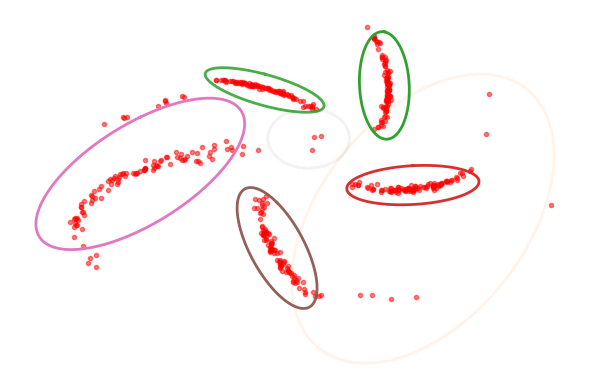

In [4]:
num_epochs = 1000
K, N, D = 15, 2, 2

prior_key, key = jr.split(key)
pgm_prior_params = init_pgm_param(prior_key, K, N, alpha=0.05 / K, niw_conc=0.5)

encoder_key, key = jr.split(key)
encoder, encoder_params = init_gresnet(encoder_key, D, [(40, jnp.tanh), (40, jnp.tanh), (2 * N, gaussian_info)])

decoder_key, key = jr.split(key)
decoder, decoder_params = init_gresnet(decoder_key, N, [(40, jnp.tanh), (40, jnp.tanh), (2 * D, gaussian_mean)])
loglike = make_loglike(decoder)

pgm_key, key = jr.split(key)
pgm_params = init_pgm_param(pgm_key, K, N, alpha=1.0, niw_conc=1.0, random_scale=3.0)

plot_key, key = jr.split(key)
plot = make_plotter_2d(key, encoder, decoder, data, num_clusters, (pgm_params, decoder_params, encoder_params))

grad_key, key = jr.split(key)
gradfun = make_gradfun(grad_key, run_inference, encoder, loglike, pgm_prior_params, 1, num_datapoints, num_batches, 1e4)

schedule = optax.linear_schedule(
    init_value=1e-3,
    end_value=1e-4,
    transition_steps=num_epochs,
)
nn_optim = optax.adamw(schedule)
nn_opt_state = nn_optim.init((decoder_params, encoder_params))

pgm_optim = optax.sgd(learning_rate=1e-3)
pgm_opt_state = pgm_optim.init(pgm_params)

for epoch in range(num_epochs):
    (pgm_grads, decoder_grads, encoder_grads), elbo = gradfun(
        (pgm_params, decoder_params, encoder_params), get_batch(epoch)
    )

    nn_updates, nn_opt_state = nn_optim.update(
        (decoder_grads, encoder_grads), nn_opt_state, (decoder_params, encoder_params)
    )
    (decoder_params, encoder_params) = optax.apply_updates((decoder_params, encoder_params), nn_updates)

    pgm_updates, pgm_opt_state = pgm_optim.update(pgm_grads, pgm_opt_state, pgm_params)
    pgm_params = optax.apply_updates(pgm_params, pgm_updates)

plot((pgm_params, decoder_params, encoder_params))